In [1]:
# Question 1: Autoencoder

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

In [3]:
# Define the transformation for the dataset
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))  # Normalize to [-1, 1]
])

# Load the MNIST dataset
train_dataset = datasets.MNIST(root='./data', train=True, transform=transform, download=True)
test_dataset = datasets.MNIST(root='./data', train=False, transform=transform, download=True)

# Create data loaders
batch_size = 128
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Check the size of the datasets
len(train_dataset), len(test_dataset)

(60000, 10000)

In [4]:
class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        
        # Encoder
        self.encoder = nn.Sequential(
            nn.Linear(28 * 28, 256),
            nn.ReLU(),
            nn.Linear(256, 128),
            nn.ReLU()
        )
        
        # Decoder
        self.decoder = nn.Sequential(
            nn.Linear(128, 256),
            nn.ReLU(),
            nn.Linear(256, 28 * 28),
            nn.Tanh()  # Since we normalized images to [-1, 1]
        )
    
    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

# Instantiate the model
autoencoder = Autoencoder()

In [5]:
# Training parameters
epochs = 10
lr = 0.001

# Define the loss and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(autoencoder.parameters(), lr=lr)

# Training loop
for epoch in range(epochs):
    for batch_idx, (data, _) in enumerate(train_loader): 
        # Flatten the images
        data = data.view(data.size(0), -1)
        
        # Forward pass
        outputs = autoencoder(data)
        loss = criterion(outputs, data)
        
        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
    print(f"Epoch [{epoch+1}/{epochs}], Loss: {loss.item():.4f}")

Epoch [1/10], Loss: 0.0533
Epoch [2/10], Loss: 0.0340
Epoch [3/10], Loss: 0.0269
Epoch [4/10], Loss: 0.0284
Epoch [5/10], Loss: 0.0229
Epoch [6/10], Loss: 0.0231
Epoch [7/10], Loss: 0.0208
Epoch [8/10], Loss: 0.0184
Epoch [9/10], Loss: 0.0197
Epoch [10/10], Loss: 0.0181


In [6]:
# Calculate the number of parameters in the encoder and decoder
encoder_params = sum(p.numel() for p in autoencoder.encoder.parameters())
decoder_params = sum(p.numel() for p in autoencoder.decoder.parameters())

encoder_params, decoder_params

(233856, 234512)

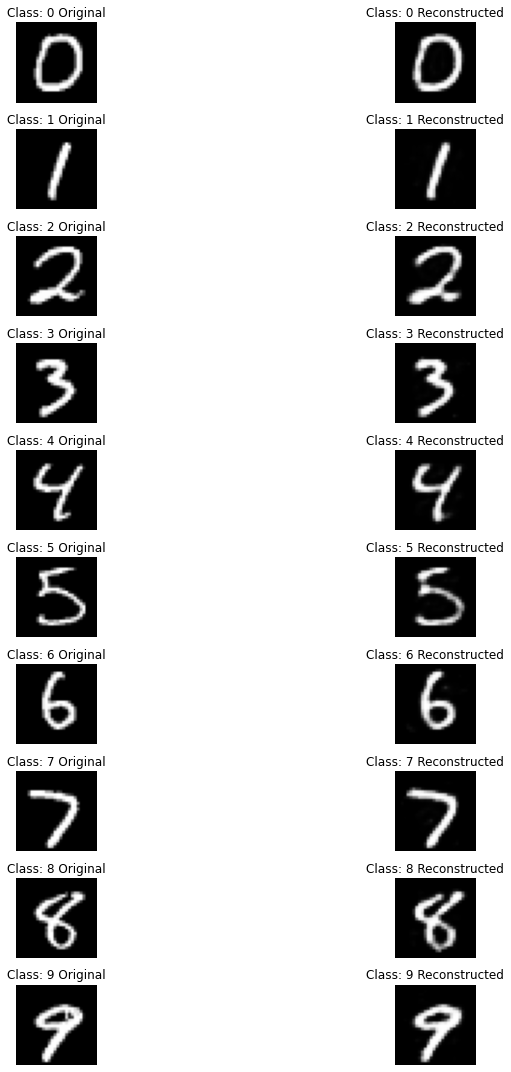

In [42]:
# Get a batch of test images
data_iter = iter(test_loader)
images, labels = next(data_iter)

# Flatten and reconstruct the images using the autoencoder
images_flattened = images.view(images.size(0), -1)
reconstructed = autoencoder(images_flattened)

# Reshape the reconstructed images to the original shape
reconstructed = reconstructed.view(batch_size, 1, 28, 28)

# Display original and reconstructed images (for 2 images of each class)
fig, axs = plt.subplots(10, 2, figsize=(15,15))
for i in range(10):
    idxs = (labels == i).nonzero()[:2]
    for j, idx in enumerate(idxs):
#         axs[i, j*2].imshow(images[idx].squeeze().numpy(), cmap='gray')
#         axs[i, j*2].axis('off')
#         axs[i, j*2+1].imshow(reconstructed[idx].squeeze().detach().numpy(), cmap='gray')
#         axs[i, j*2+1].axis('off')
                # Original image
        axs[i, 0].imshow(images[idx].squeeze().numpy(), cmap='gray')
        axs[i, 0].axis('off')
        axs[i, 0].set_title(f"Class: {i} Original")
        
        # Reconstructed image
        axs[i, 1].imshow(reconstructed[idx].squeeze().detach().numpy(), cmap='gray')
        axs[i, 1].axis('off')
        axs[i, 1].set_title(f"Class: {i} Reconstructed")

plt.tight_layout()
plt.show()

In [8]:
# Question 2

In [23]:
# Define the convolutional autoencoder
class ConvAutoencoder(nn.Module):
    def __init__(self):
        super(ConvAutoencoder, self).__init__()
        
        # Encoder
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=3, padding=1),  # [batch, 16, 28, 28]
            nn.ReLU(),
            nn.MaxPool2d(2, 2),  # [batch, 16, 14, 14]
            nn.Conv2d(16, 32, kernel_size=3, padding=1),  # [batch, 32, 14, 14]
            nn.ReLU(),
            nn.MaxPool2d(2, 2)  # [batch, 32, 7, 7]
        )
        
        # Decoder
        self.decoder = nn.Sequential(
            nn.Conv2d(32, 16, kernel_size=3, padding=1),  # [batch, 16, 7, 7]
            nn.ReLU(),
            nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True),  # [batch, 16, 14, 14]
            nn.Conv2d(16, 16, kernel_size=3, padding=1),  # [batch, 16, 14, 14]
            nn.ReLU(),
            nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True),  # [batch, 16, 28, 28]
            nn.Conv2d(16, 1, kernel_size=3, padding=1),  # [batch, 1, 28, 28]
            nn.Tanh()
        )
    
    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

In [11]:
# Training parameters
epochs = 10 
lr = 0.001

# Define the loss and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(conv_autoencoder.parameters(), lr=lr)

# Training loop
for epoch in range(epochs):
    for batch_idx, (data, _) in enumerate(train_loader): 
        # Flatten the images
        data = data.view(data.size(0), -1)
        
        # Forward pass
        outputs = autoencoder(data)
        loss = criterion(outputs, data)
        
        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
    print(f"Epoch [{epoch+1}/{epochs}], Loss: {loss.item():.4f}")

Epoch [1/10], Loss: 0.0160
Epoch [2/10], Loss: 0.0152
Epoch [3/10], Loss: 0.0188
Epoch [4/10], Loss: 0.0160
Epoch [5/10], Loss: 0.0182
Epoch [6/10], Loss: 0.0178
Epoch [7/10], Loss: 0.0167
Epoch [8/10], Loss: 0.0181
Epoch [9/10], Loss: 0.0172
Epoch [10/10], Loss: 0.0162


In [19]:
# Calculate the number of parameters in the encoder and decoder of the convolutional autoencoder
conv_encoder_params = sum(p.numel() for p in conv_autoencoder.encoder.parameters())
conv_decoder_params = sum(p.numel() for p in conv_autoencoder.decoder.parameters())

conv_encoder_params, conv_decoder_params

(4800, 7089)

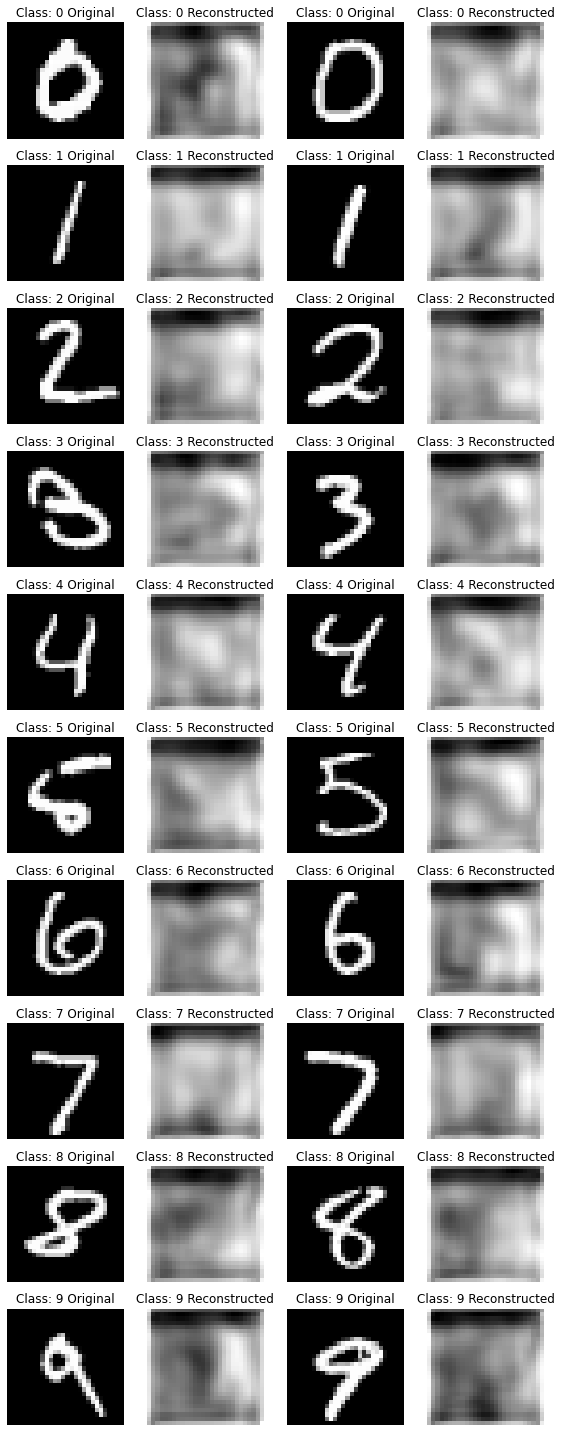

In [40]:
# Get a batch of test images
data_iter = iter(test_loader)
images, labels = next(data_iter)

# Ensure the images have the shape [batch_size, 1, 28, 28]
if len(images.shape) != 4:
    images = images.unsqueeze(1)

# Reconstruct the images using the convolutional autoencoder
reconstructed = conv_autoencoder(images)

# Display original and reconstructed images (for 2 images of each class)
fig, axs = plt.subplots(10, 4, figsize=(8,20))
for i in range(10):
    idxs = (labels == i).nonzero(as_tuple=True)[0][:2]
    for j, idx in enumerate(idxs):
        # Original image
        axs[i, j*2].imshow(images[idx].squeeze().numpy(), cmap='gray')
        axs[i, j*2].axis('off')
        axs[i, j*2].set_title(f"Class: {i} Original")
        
        # Reconstructed image
        axs[i, j*2+1].imshow(reconstructed[idx].squeeze().detach().numpy(), cmap='gray')
        axs[i, j*2+1].axis('off')
        axs[i, j*2+1].set_title(f"Class: {i} Reconstructed")
        
plt.tight_layout()
plt.show()
